# Model Comparision

We have trained both Faster R-CNN and YOLOv8 model on KITTI dataset for 4 epochs and the corresponding models are saved with their best weights. Now we will compare both of these models and check which one is best model as per the evaluation statistics and suitable for real life application.

## Comparison of Trained Models of Faster R-CNN and YOLOv8

In [189]:
# Import necessary liimport torch
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from ultralytics import YOLO  # Assuming YOLOv8 is implemented as a YOLO class
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import gc

### Load the models

Loading both the trained models and viewing their structure.

In [2]:
# Load faster R-CNN model

CATEGORY_MAPPING = {"Car": 1, "Pedestrian": 2, "Cyclist": 3, "Van": 4,
                    "Truck": 5, "Person_sitting": 6, "Tram": 7, "Misc": 8}

# Load the model and weights
faster_rcnn_model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
num_classes = len(CATEGORY_MAPPING) + 1  # 8 classes + background
in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
faster_rcnn_model.load_state_dict(torch.load('faster-rcnn-checkpoints/best_model_weights.pth'))
faster_rcnn_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
# Load YOLOv8 model
yolov8_model = YOLO("runs/detect/train/weights/best.pt")
yolov8_model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### Define Test Dataset and Evaluation Metrics

In [135]:
# Define test dataset and test-DataLoader
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, {}  # Return empty target dict since we're not using labels

transform = transforms.Compose([ToTensor()])
test_dataset = CustomImageDataset('datasets/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

### Evaluate Models on Test dataset

In [119]:
# Evaluation metrics of faster-rcnn
# Manually input the recorded values for each epoch
import pandas as pd

data = {
    'epoch': [1, 2, 3, 4],
    'training Loss': [0.7261, 0.5199, 0.4498, 0.4118],
    'mAP': [0.1463, 0.2574, 0.3050, 0.3341],
    'precision': [0.3077, 0.4882, 0.5667, 0.6160],
    'recall': [0.3070, 0.4196, 0.4627, 0.4684],
    'training_time (s)': [33290.64, 33207.58, 33409.82, 33670.88],
    'inference_time (s)': [3406.97, 3428.70, 3450.52, 3695.79]
}

# Create the DataFrame
fasterrcnn_metrics_df = pd.DataFrame(data)

# Evaluation metrics of YOLOv8 from results.csv
yolov8_metrics_df = pd.read_csv('runs/detect/train/results.csv')

### Evaluation Metrics

In [121]:
# Processing befor merging these dataframes
# Rename YOLOv8 columns to match Faster R-CNN columns
yolov8_metrics_df.rename(columns={
    'metrics/precision(B)': 'precision',
    'metrics/recall(B)': 'recall',
    'metrics/mAP50(B)': 'mAP',
    'metrics/mAP50-95(B)': 'mAP_50-95',
}, inplace=True)


# Select relevant columns
yolov8_metrics_df = yolov8_metrics_df[['epoch', 'precision', 'recall', 'mAP']]

yolov8_metrics_df.head()

# Merge the dataframes on the 'epoch' column
metrics_df = pd.merge(
    fasterrcnn_metrics_df[['epoch', 'mAP', 'precision', 'recall']],
    yolov8_metrics_df[['epoch', 'mAP', 'precision', 'recall']],
    on='epoch',
    suffixes=('_fasterrcnn', '_yolov8')
)

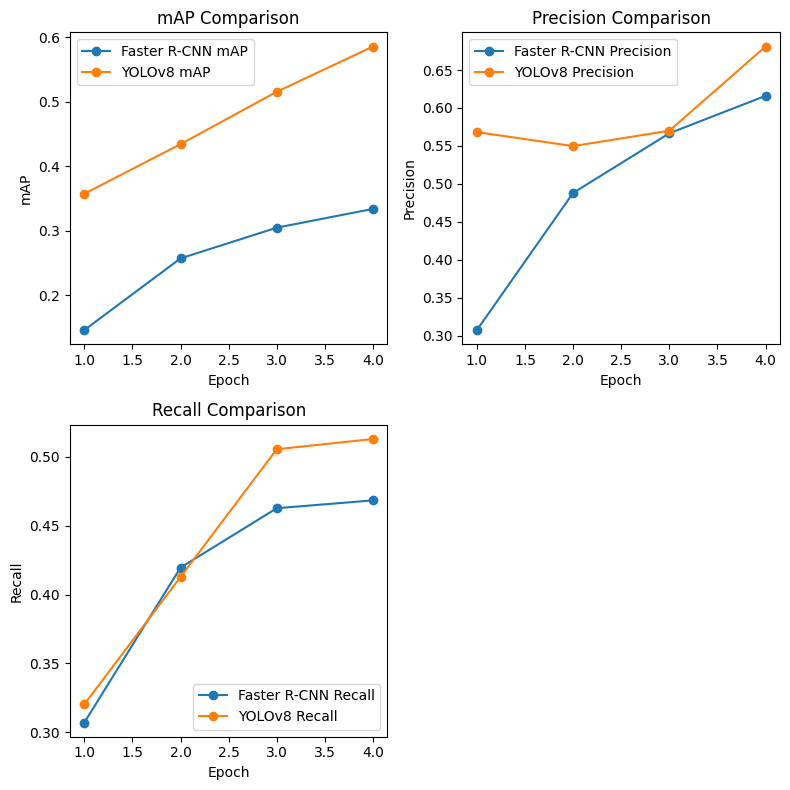

In [221]:
import matplotlib.pyplot as plt

# Example plotting code
plt.figure(figsize=(8, 8))

# Plot mAP
plt.subplot(2, 2, 1)
plt.plot(metrics_df['epoch'], metrics_df['mAP_fasterrcnn'], label='Faster R-CNN mAP', marker='o')
plt.plot(metrics_df['epoch'], metrics_df['mAP_yolov8'], label='YOLOv8 mAP', marker='o')
plt.title('mAP Comparison')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(metrics_df['epoch'], metrics_df['precision_fasterrcnn'], label='Faster R-CNN Precision', marker='o')
plt.plot(metrics_df['epoch'], metrics_df['precision_yolov8'], label='YOLOv8 Precision', marker='o')
plt.title('Precision Comparison')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(metrics_df['epoch'], metrics_df['recall_fasterrcnn'], label='Faster R-CNN Recall', marker='o')
plt.plot(metrics_df['epoch'], metrics_df['recall_yolov8'], label='YOLOv8 Recall', marker='o')
plt.title('Recall Comparison')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.savefig("metric.png")
plt.show()


From the above plots, we can see that the metrics performance of YOLOv8 is better than the Faster R-CNN model, with fewer (4) epochs. This can be plausible because, newer version of YOLO is more robust and its improved architecture may result in the higher performance of the model. However, since it is a limited number epochs, we can maybe increase the number of epochs and see the actual performance of these model.

### Prediction on a common Images

Predict some images by both the models and compare the outputs, if there are any misclassifications.


image 1/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000000.png: 224x640 1 Car, 79.3ms
image 2/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000001.png: 224x640 3 Cars, 98.3ms
image 3/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000002.png: 224x640 8 Cars, 89.4ms
image 4/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000003.png: 224x640 4 Cars, 76.0ms
image 5/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000004.png: 224x640 1 Car, 1 Truck, 148.3ms
image 6/201 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitt

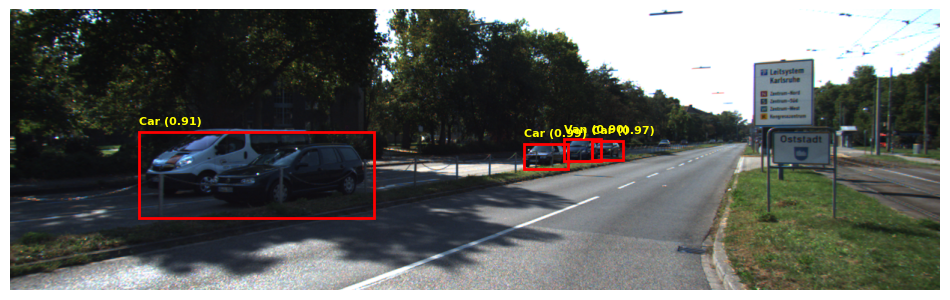

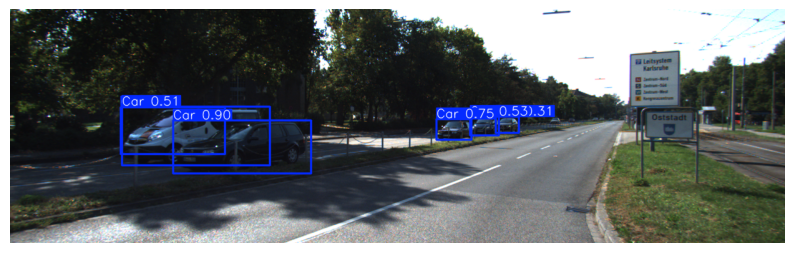

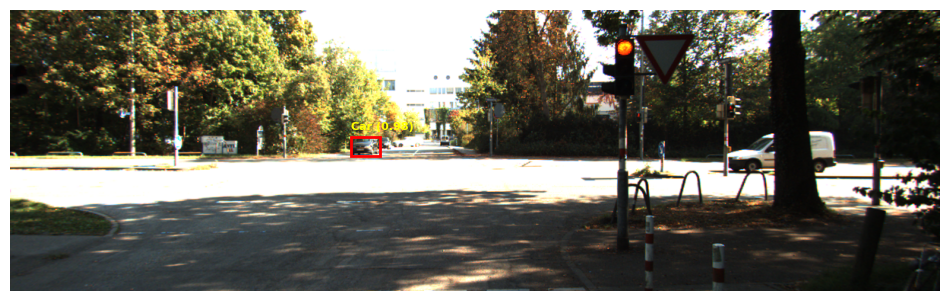

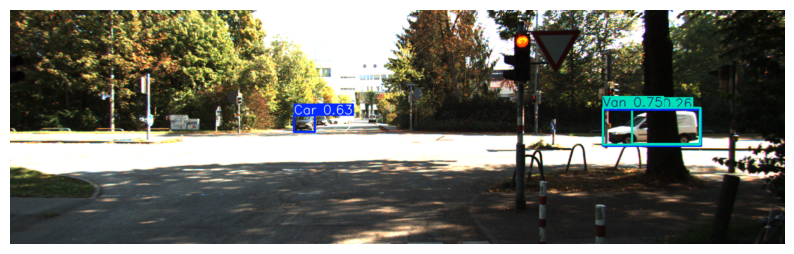

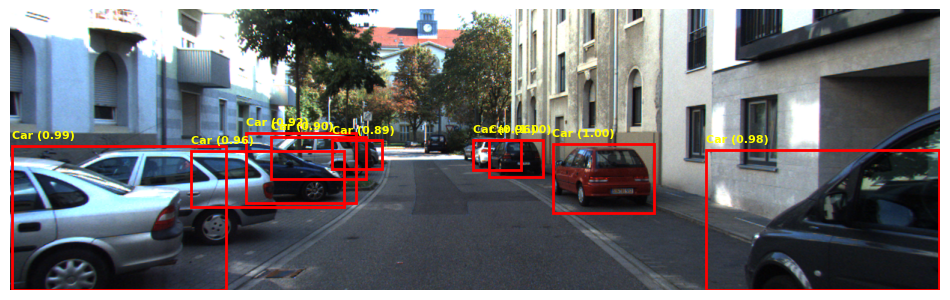

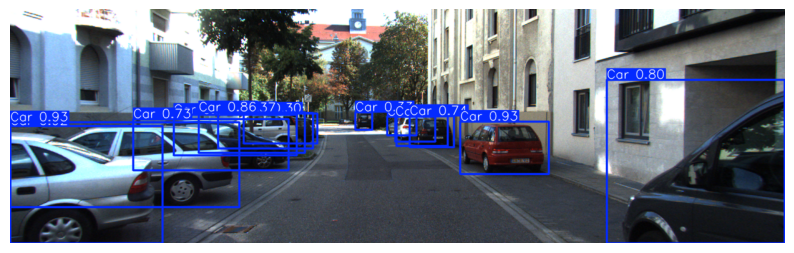

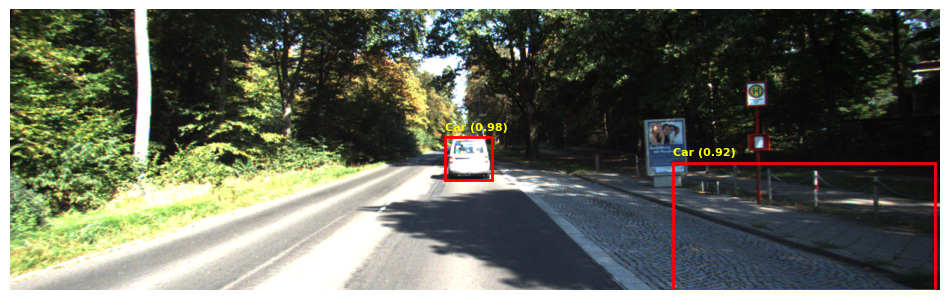

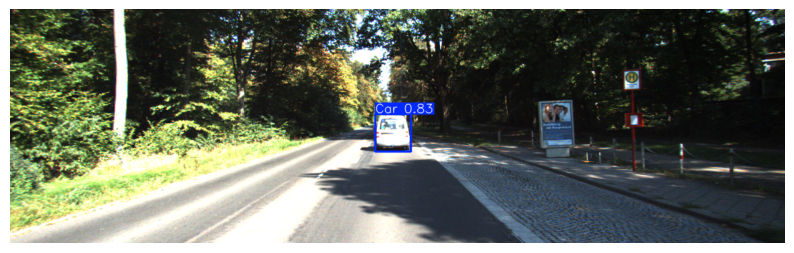

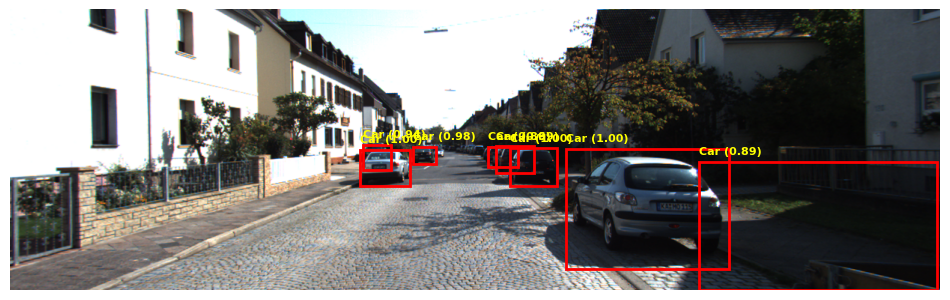

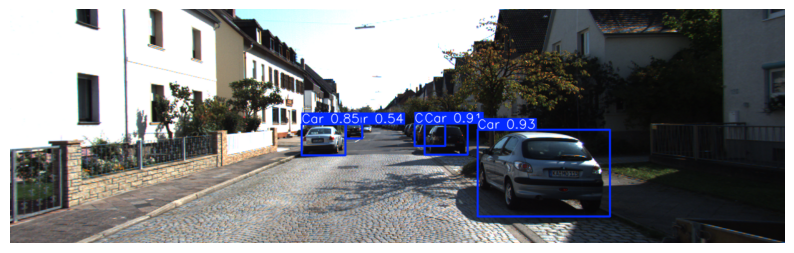

In [233]:
# Define image processing
transform = T.Compose([T.ToTensor()])

# Predict  and save the results of YOLO images
# Directory for YOLO results
yolo_results_dir = "yolo_results"
# Create the results directory if it does not exist
os.makedirs(yolo_results_dir, exist_ok=True)
# Predict with YOLOv8 and save results
yolov8_model.predict("datasets/test", save=True, project=yolo_results_dir, name='results')


def visualize_fasterrcnn_predictions(image, predictions, category_mapping):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()

    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > 0.85:  # Filter out low confidence predictions
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            label_name = list(category_mapping.keys())[list(category_mapping.values()).index(int(label))]
            plt.text(x_min, y_min - 10, f'{label_name} ({score:.2f})', color='yellow', fontsize=8, fontweight='bold')
            plt.axis('off')

    plt.show()

# Visualize objects with bounding boxes and with corresponding labels for YOLO model
def visualize_yolov8_predictions(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Ensure image is in RGB mode

    # Open and display the YOLO results
    result_image_path = os.path.join(yolo_results_dir, 'results', os.path.basename(image_path))
    result_img = Image.open(result_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()

# Define paths
image_dir = 'datasets/test/'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
sample_images = random.sample(image_files, 5)  # Randomly select 5 images

for image_file in sample_images:
    image_path = os.path.join(image_dir, image_file)
    
    # Open and prepare image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform prediction with Faster R-CNN
    with torch.no_grad():
        predictions = faster_rcnn_model(image_tensor.to(device))

    # Visualize Faster R-CNN results
    visualize_fasterrcnn_predictions(image, predictions, CATEGORY_MAPPING)

    # Visualize YOLOv8 results
    visualize_yolov8_predictions(image_path)


From the above detections we can see that the confidence in which Faster R-CNN predicts the object of intrest is high, compared to the lessser confidence of YOLOv8. However, it is noted that there are some misclassifactions done by Faster R-CNN which is the result of less number of training epochs. If the number of epoch is higher, there is change of more accurate prediction of Faster R-CNN compared to YOLOv8.

### Inference Time

In [193]:
# Path to the image
image_path = "datasets/test/000013.png" # Example image

# Load the image
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

In [201]:
# Predict using Faster R-CNN

# Move the model and image to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
faster_rcnn_model.to(device)
image_tensor = image_tensor.to(device)

# Measure inference time for Faster R-CNN
start_time = time.time()
with torch.no_grad():
    fasterrcnn_predictions = faster_rcnn_model(image_tensor)
fasterrcnn_inference_time = time.time() - start_time

# Print the inference time
print(f"Faster R-CNN Inference Time: {fasterrcnn_inference_time:.4f} seconds")

Faster R-CNN Inference Time: 4.9641 seconds


In [203]:
# Predict using YOLOv8

# Measure inference time for YOLOv8
start_time = time.time()
yolov8_results = yolov8_model(image_path)
yolov8_inference_time = time.time() - start_time

# Print the inference time
print(f"YOLOv8 Inference Time: {yolov8_inference_time:.4f} seconds")


image 1/1 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000013.png: 224x640 7 Cars, 1 Van, 1 Truck, 212.8ms
Speed: 4.0ms preprocess, 212.8ms inference, 15.7ms postprocess per image at shape (1, 3, 224, 640)
YOLOv8 Inference Time: 0.2974 seconds


From the above comparison we can see that the prediction time (including pre processing, prediction and post processing) of Faster R-CNN is 4.9641 which is so high compared to YOLOv8 which is only 0.2974.

From small number of epoch, YOLOv8 performs really well, with high mean average precision, precision and recall scores which are superior to that of Faster R-CNN. YOLO also performs good in real time object detection, with only 0.2974 inference time for a single image as compared to Faster R-CNN.